In [2]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import *
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')

/Users/jeffreyshragge/opt/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/jeffreyshragge/opt/anaconda3/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


![title](data/TITLE.png)

### <h1><center>Module 15: Practical Filtering</center></h1>

When confronted with geophysical data there are numerous situations where you seek to alter the frequency content of the signals in some particular fashion.  For example, four key operations are:

1. **Low-pass filtering:** Removal of frequencies higher than some cut-off frequency $f_C$.  This is also known as high-cut filtering.
2. **High-pass filtering:** Removal of frequencies lower than some cut-off frequency $f_C$.  This is also known as low-cut filtering.
3. **Bandpass filtering:** Removal of frequencies lower than low-cutoff frequency $f_{LC}$ and higher than high-cutoff frequency $f_{HC}$. 
4. **Band-reject filtering:** Removal of frequencies in the range $[f_{LC},f_{HC}]$.  This is also known as notch filtering.

The notes in this section will explore some issues related to these filtering operations. Let's first look at the effects of introducting zeros and poles on our signals.

# Effects of Zeros in the Transfer Function

Let's first examine the effect a zero has in the transfer function by looking at an example:

**Q:** We want a filter that will have a zero gain at a frequency of 400Hz. Calculate the transfer function $H(z)$ if the sampling rate is $f_s=2000$ Hz.

**A:** In this case we are going to look at how a filter created in the full $z$ space affect the values on the unit circle where $\left.z\right|_{r=1} = e^{i\phi}$, which corresponds to the standard frequencies we have been discussing this semester.  To create a filter, we need to introduce only one zero at $f_c=400$ Hz in the numerator, where $f_c$ is the frequency to cut. Let's now evaluate where to put this zero on our normalized angular frequency axis:

$$\phi = 2\pi f_c/f_s. \tag{1}$$

Substituting $f_c=400$Hz and $f_s=2000$Hz yields the following on the z-plane $z=e^{i2\pi 400/2000}=e^{i2\pi/5}$.  Thus, let's construct an example of a transfer function $H(z)$ given by 

$$H(z) = 1-e^{i2\pi/5} z^{-1}. \tag{2}$$

Note that this example transfer function is not intended to anything special and is just for illustration purposes.

Thus, when evaluated on the unit circle, this transfer function will be identically zero!  Let's see how $H(z)$ will affect all other frequencies (note that I'm plotting the x-axis with respect to the expected frequency range of $f=\pm1000$Hz, which is the Nyquist frequency).  Here, I plot the magnitude spectra of two functions: (1) an all-pass filter (that advances the time series by one unit) when $H(z)=z$ in black; and (2) a filter with a broad notch at $f_c=400$Hz in blue.

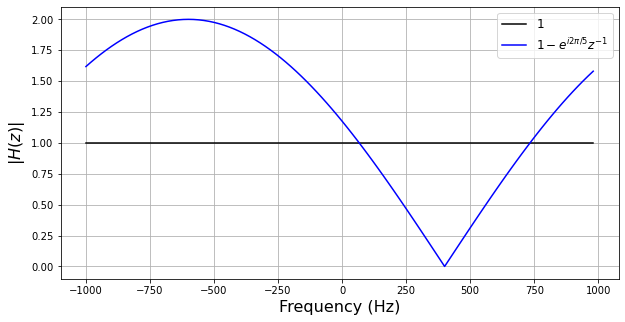

In [2]:
# Frequency Response: Single zero at 2*pi*fc/fs
# . . the final command creates a frequency axis between -pi and pi
fc,fs,w =400, 2000, np.fft.fftshift(np.fft.fftfreq(100,d=1/(2*np.pi))) 

# . . Define z
z = np.exp(1j*w)

# . . Define filter
H0 = np.ones(np.size(w))
H = 1-z**(-1)*np.exp(1j*2*np.pi*fc/fs) 

# . . Plot filter magnitude spectrum
plt.figure(figsize=(10,5))
plt.plot(w*fs/(2*np.pi),abs(H0),'k',w*fs/(2*np.pi), abs(H),'b')
plt.xlabel('Frequency (Hz)',size=16)
plt.ylabel('|$H(z)$|',size=16)
plt.legend(['$1$','$1-e^{i2\pi/5}z^{-1}$'],fontsize=12)
plt.grid(True)
plt.show()

**Figure 1. Example showing the result of including one zero at 400 Hz in the transfer function.**

Note that we have successfully used a zero to eliminate frequency at $f=f_c/f_s=0.2$ (here $400$Hz).  However, this has also significantly affected all of the other frequencies in spectrum. (Ideally, the value of $H(z)$ at all other values of $f_c/f_s$ should be one.) We also did not look at the **phase** of the filter response. For practical filtering, we generally are looking for a filter that alters the magnitude response of the input signal $X(z)$, but does not affect its phase.  

Finally, to look at how this would apply to an input $x[n]$ we can write the following:

$$Y(z) = H(z) X(z) = \left(1-e^{i2\pi/5} z^{-1}\right) X(z) = X(z)- e^{i2\pi/5} z^{-1} X(z). \tag{3}$$

Because $z^{-1}$ represents a unit **delay**, this corresponds to the following discrete time-domain filtering operation:

$$y[n] = x[n]-e^{i2\pi/5}x[n-1].\tag{4}$$

### Real coefficients

Let's now get rid of the complex coefficients.  We can do this by recognizing that the Fourier domain has both positive and negative frequency components.  Thus, let's look at removing $f_c=-400$ Hz as well, which should follow the exact same approach as in equation 2 but with $f_c\rightarrow-f_c$.  

$$H(z) = 1-e^{-i2\pi/5}z^{-1}. \tag{5}$$

Multiplying together the filter expressions in equations 2 and 5 generates a combined filter response:

$$
\begin{eqnarray}
H(z) &=& (1-e^{i2\pi/5}z^{-1})(1-e^{-i2\pi/5}z^{-1}) \tag{6a}\\
&=&1 - 2\cos(2\pi/5)z^{-1}+z^{-2}\tag{6b}
\end{eqnarray}
$$

Let's look at the filter response now:

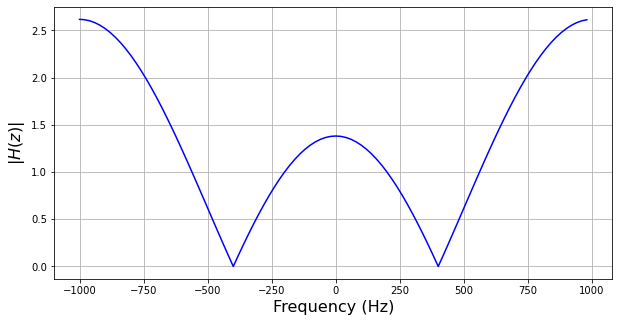

In [3]:
# Frequency Response: Complex Conjugate zeroes at 0.4 pi
fc,fs,w = 400,2000, np.fft.fftshift(np.fft.fftfreq(100,d=1/(2*np.pi)))

# . . Define z
z = np.exp(1j*w)

# . . Define filter

Ha = 1-z**(-1)*np.exp(+1j*2*np.pi*fc/fs) 
Hb = 1-z**(-1)*np.exp(-1j*2*np.pi*fc/fs) 

H2 = Ha*Hb

# . . Plot filter magnitude spectrum
plt.figure(figsize=(10,5))
plt.plot(w*fs/(2*np.pi), abs(H2),'b')
plt.xlabel('Frequency (Hz)',size=16)
plt.ylabel('|$H(z)$|',size=16)
plt.grid(True)
plt.show()

**Figure 2. Example showing the result of including two symmetric zeros at $\pm$400 Hz introducted into the transfer function.**


Interesting! We now have real coefficients and have introduced a second zero at $-400$ Hz.  Thus, the final difference equation is given by:

$$Y(z) = H(z) X(z) = \left( 1 - 2\cos(2\pi/5)z^{-1}+z^{-2}\right) X(z) \tag{8a}$$

Reverting back to the discrete time domain $n$ yields the following operation:

$$y[n] = x[n]-2\cos(2\pi/5)x[n-1]+x[n-2]. \tag{8b}$$

The impulse response of this filtering operator is given by the following stem plot.  

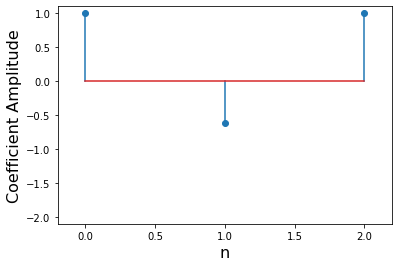

In [4]:
h = [1, -2*np.cos(2*np.pi*fc/fs), 1]
n = [0,1,2]

plt.stem(n,h)
plt.xlim([-.2, 2.2])
plt.ylim([-2.1, 1.1])
plt.xlabel('n',size=16)
plt.ylabel('Coefficient Amplitude',size=16)
plt.show()

**Figure 3. The equivalent filter to the above filtering operation.**

Note that the notching frequency is controlled by the value of the coefficient at $n=1$.  Make this value larger (up to a maximum of 2) will increase the value of cut frequency $f_c$.  Interestingly, when $f_c=0$ then we recover the second-derivative finite-difference operator approximation.  

Thus, if we wanted to apply this filtering operator in the time domain, we could **convolve** the expression $[1, -2\cos(2\pi/5), 1]$ with our time-domain signal $x[n]$.

### Filtering out at Nyquist frequency

Now let's say that we also want to include a third zero at the Nyquist frequency, $f_c/f_s=0.5$ which is here $\pm1000$Hz.  This corresponds to introducing an additional multiplicative filter:

$$H(z) = 1-e^{-i\pi}z^{-1} = 1+z^{-1}.\tag{9}$$

Note that this equation applies to both $f_c=\pm1000$Hz.  Multiplying these through yields 

$$
\begin{eqnarray}
H(z) &=& \left(1 - 2\cos(2\pi/5)z^{-1}+z^{-2}\right)\left(1+z^{-1}\right). \tag{10}
\end{eqnarray}
$$

Let's look at how this has affected the filter's magnitude spectrum:

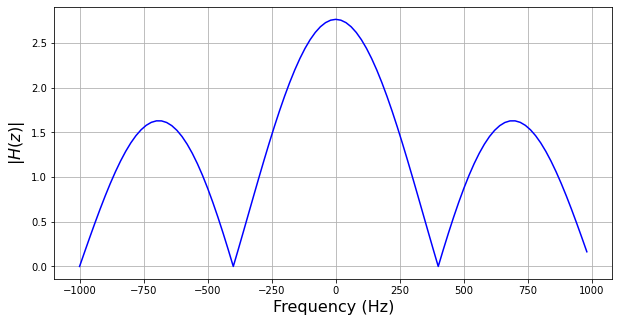

In [5]:
# Frequency Response: Complex Conjugate zeroes at 0.4 pi and at pi
fc,fs,w =400,2000, np.fft.fftshift(np.fft.fftfreq(100,d=1/(2*np.pi)))

# . . Define z
z = np.exp(1j*w)

# . . Define function
H3 = (1 - 2*np.cos(2*np.pi*fc/fs)*z**(-1) + z**(-2))*(1+z**(-1))

# . . Plot filter magnitude spectrum
plt.figure(figsize=(10,5))
plt.plot(w*fs/(2*np.pi), abs(H3),'b')
plt.xlabel('Frequency (Hz)',size=16)
plt.ylabel('|$H(z)$|',size=16)
plt.grid(True)
plt.show()

**Figure 4. The filtering operation in Figure 2, but now with zeros at Nyquist frequency.**

We can now see that we have also (nearly) removed the frequency at $f_c/f_s=0.5$ (here $ \pm 1000$ Hz).  Let's look a the impulse response with the three zeros.

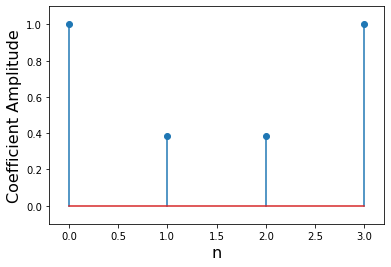

In [6]:
h2 = np.convolve([1, -2*np.cos(0.4*np.pi), 1],[1, 1])
n = [0,1,2,3]

plt.stem(n,h2)
plt.xlim([-.2, 3.2])
plt.ylim([-0.1, 1.1])
plt.xlabel('n',size=16)
plt.ylabel('Coefficient Amplitude',size=16)
plt.show()

**Figure 5. The filter as in Figure 3, but now designed to remove at Nyquist frequency as well.**


Applying this filter in the time-domain would again be the equivalent of performing a **convolution** with the filter coefficients defined in the plot above.

### Summary - Effects of adding zeros

1. By adding zeros at a specific frequency, we pass zero energy at that frequency in our filter.
2. We have to use conjugate symmetric zeros to obtain real coefficients.
3. We have to introduce delays to obtain a causal form of the filter.
4. This filter will always be FIR (finite impulse response) because there is no dependence on multiple output values $y[n]$ to form a recursion relationship.


# Effect of Poles on Frequency Response 

Let's examine a filtering desire related to the above that we can address with adding **poles** to the denominator of the expression.

**Q:** We would like to apply a large 20x gain at a boosting frequency of $f_b=200$ Hz. What would the transfer function $H(z)$ be if the sampling rate is $f_s=2000$ Hz.

**A:** Let's examine a solution using only one **pole**.  However, if the pole were located on the unit circle then we would have an infinite gain due to zero division.  Thus, let's look at a solution where the pole is at $f_b=200$Hz is in the demoninator close to (and inside) of the unit circle at r=0.95. (The choice of $0.95$ will be clear below.) 

$$\phi = 2\pi f_b/f_s. \tag{11}$$

Substituting $f_b=200$ Hz and $f_s=2000$ Hz yields the following on the z-plane $z=e^{i2\pi 200/2000}=e^{i\pi/5}$.  Thus, let's construct a transfer function given by:

$$H(z) = \frac{1}{1-0.95e^{i\pi/5}z^{-1}}. \tag{12}$$

We'll see that the magnitude $|H(z)| = \frac{1}{|1-0.95|}=\frac{1}{0.05}=20$.  Thus, we will observe a 20$\times$ magnification at the desired frequency.  What about the other frequencies?

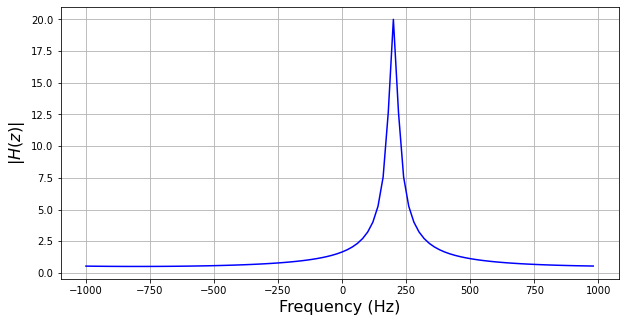

In [7]:
# Frequency Response for single pole at 0.2pi
fb,fs,r,w =200,2000,0.95,np.fft.fftshift(np.fft.fftfreq(100,d=1/(2*np.pi)))

# . . Define z
z = np.exp(1j*w)

# . . Define filter
H4 = 1/(1-r*np.exp(1j*2*np.pi*fb/fs)*z**(-1))

# . . Plot filter magnitude spectrum
plt.figure(figsize=(10,5))
plt.plot(w*fs/(2*np.pi), abs(H4),'b')
plt.xlabel('Frequency (Hz)',size=16)
plt.ylabel('|$H(z)$|',size=16)
plt.grid(True)
plt.show()

**Figure 6. Effect of introducing a pole at 200 Hz at $=0.95$ which results in a 20x amplification.**

We see that there is a 20x increase at $f_b/f_s=0.1$, which is here $f_b=200$Hz. However, the frequencies about the $f_b$ are also significantly affected.  

Let's look at how equation 12 is used:

$$Y(z) = X(z) + 0.95e^{i\pi/5}z^{-1} Y(z)\tag{14}$$

Transforming this to a difference equation, one can see that it is **recursive**:

$$y[n] = x[n] + 0.95e^{i\pi/5} y[n-1]. \tag{13}$$

which mean that this is an example of a IIR filter.

### Removing complex coefficients

Similar to the previous case, let's include a second pole at the corresponding negative frequency component:

$$
\begin{eqnarray}
H(z) 
&=& \frac{1}{(1-0.95e^{i\pi/5}z^{-1})(1-0.95e^{-i\pi/5}z^{-1})} \tag{18} \\
&=& \frac{1}{1-1.9\cos(\pi/5)z^{-1}+(0.95)^2z^{-2}} \tag{19}\\
\end{eqnarray}
$$

Let's look at how this affects the transfer filter $H(z)$:

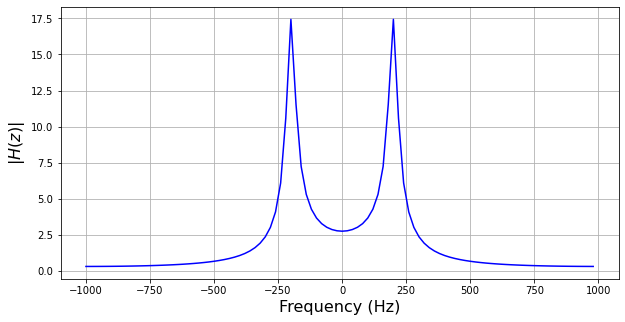

In [8]:
# Frequency Response for conjugate pole pair at +/- 0.2pi
fb,fs,r,w = 200,2000,0.95,np.fft.fftshift(np.fft.fftfreq(100,d=1/(2*np.pi)))

# . . Define z
z = np.exp(1j*w)

# . . Define filter
H4=1/((1-r*np.exp(1j*2*np.pi*fb/fs)*z**(-1))*(1-r*np.exp(-1j*2*np.pi*fb/fs)*z**(-1)))

# . . Plot filter magnitude spectrum
plt.figure(figsize=(10,5))
plt.plot(w*fs/(2*np.pi), abs(H4),'b')
plt.xlabel('Frequency (Hz)',size=16)
plt.ylabel('|$H(z)$|',size=16)
plt.grid(True)
plt.show()

**Figure 7. Effect of introducing poles at $\pm$200 Hz at $=0.95$ which results in a nearly 20x amplification.  However, it is not exactly 20x because the two filter contributions effectively interfere with each other.**


Let's look at the response of this filter in the time domain.  However, this is not as straightforward as above where we could read off the coefficients through a convolution process.  This is because of the recursive nature of the filter! However, we can estimate its response by using numpy's *lfilter* routine.

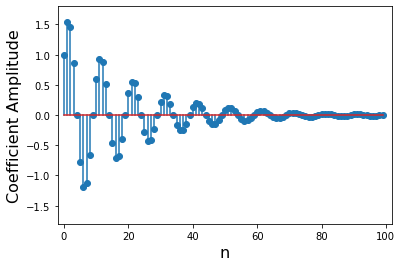

In [9]:
# Impulse response of conjugate pole pair function.
r, phi = 0.95,2*np.pi*fb/fs

# . . numerator coefficients of [1,z^-1,z^-2]
b = [1,0,0]

# . . denominator coefficients of [1,z^-1,z^-2]
a = [1, -2*r*np.cos(phi), r**2]

# . . Form impulse at start of sequence
dirac = np.repeat(0.0,100)
dirac[0] = 1

# . . Apply filter to dirac with numerator b and denominator a  
h5 = lfilter(b,a,dirac)

# . . Plot the results
plt.stem(h5)
plt.xlim([-2, 102])
plt.ylim([-1.8, 1.8])
plt.xlabel('n',size=16)
plt.ylabel('Coefficient Amplitude',size=16)
plt.show()

**Figure 8.  Equivalent time-domain convolutional filter that can be applied (note this was truncated at $n=100$ for illustration purposes).**

We see that this filter keeps on ringing with non-zero values out to a very large number of samples.

Note that applying this filter would require a **convolution** of the above filter impulse reponse with your time-series data.

## Effect of pole distance to unit circle

The next question examines what is the effect of choosing a different $r$ than 0.95?  Let's do a bit of a test here:

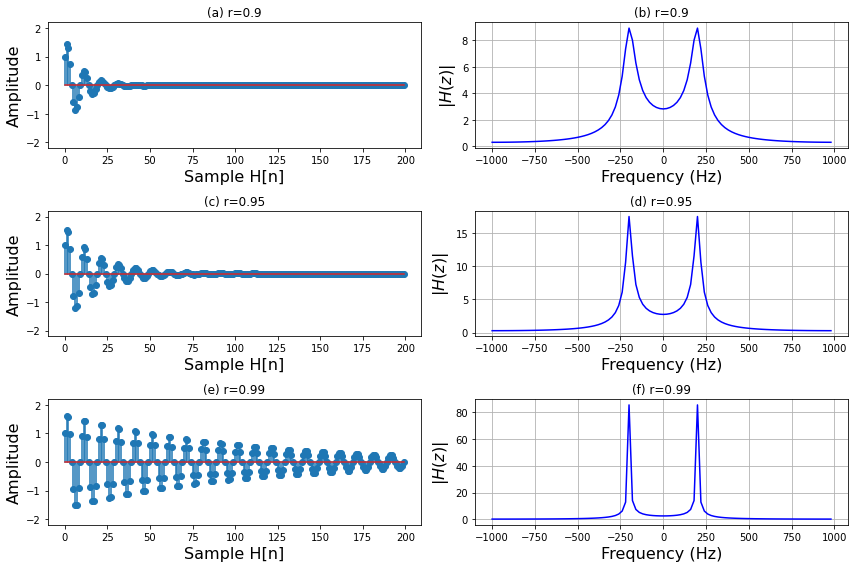

In [10]:
fb,fs=200,2000
rs= [0.9 ,0.95, 0.99]
dirac = np.repeat(0.0,200)
dirac[0] = 1
n=1

title=['(a)','(b)','(c)','(d)','(e)','(f)']

plt.figure(figsize=(12, 8))
for c in rs:
    phi = 0.2*np.pi
    r = c
    b2 = [1,0,0]
    a2 = [1, -2*r*np.cos(phi), r**2]
    h6 = lfilter(b2,a2,dirac)
    plt.subplot(3,2,n)
    plt.stem(h6)
    plt.ylim([-2.2,2.2])
    plt.xlabel('Sample H[n]',size=16)
    plt.ylabel('Amplitude',size=16)
    plt.title(title[n-1]+' r='+ str(c))

    plt.subplot(3,2,n+1)
    H5=1/((np.exp(1j*w)-r*np.exp(1j*2*np.pi*fb/fs))*(np.exp(1j*w)-r*np.exp(-1j*2*np.pi*fb/fs)))

    plt.plot(w*fs/(2*np.pi), abs(H5),'b')
    plt.xlabel('Frequency (Hz)',size=16)
    plt.ylabel('|$H(z)$|',size=16)
    plt.title(title[n]+' r='+ str(c))
    plt.grid(True)
    n=n+2
    
plt.tight_layout() # . . Make it so that the subplots don't overlap
plt.show()

**Figure 9. Illustration of the effect of changing $r$. (a) $r=0.9$ and (b) associated Fourier magnitude spectrum. (c) $r=0.95$ and (d) associated Fourier magnitude spectrum.  (e) $r=0.99$ and (f) associated Fourier magnitude spectrum.**

We see that moving $r\rightarrow 1$, results in a more spatially localized frequency-domain filter (right-hand side); however, the trade off is that the time-series decays much more slowly (left-hand side), meaning that you need a much longer filter in order to realize the **convolutional** filtering operation.  (Again, compression in one domain is expansion in the conjugate domain!)

## Summary Comments

1. Locating a pole close to the unit circle (e.g., $r=0.99$) will result in an oscillatory IIR filter that can boost a signal at the chosen frequency $f_b$. 

2. As pole gets closer to origin, the resulting filter effect is stronger and more localized, but without any change in oscillation frequency that is controlled by the $f_b$ coefficient. 

# Low-pass Filtering with FIR operators

Recall that the magnitude of the frequency response of $H(z)$ determines the filter type (e.g., low-pass, high-pass).  For a FIR filter we may only use **zeros** to adjust the magnitude of the filter.  In addition, as the order of the filter increases, additional **poles at z=0** are required due to causality arguments.

Here are a number of questions related to low-pass filter (LPF) design:

1. What is the Fourier transform of a pulse?

2. What is the ideal frequency form of a LPF?

3. What is the impulse response of an ideal LPF?

4. What is the method to design the most ideal LPF?

Using three coefficients (in the numerator), we want to design a FIR low-pass filter with cut-off frequency $f_c=500$ Hz where our sampling rate is $f_s=2000$ Hz.  We know that we are looking at $\phi = 2\pi f_c/f_s = 0.5\pi$. However, we do not yet know how to find the coefficients $[b_0,b_1,b_2]$ of the following transfer function:

$$H(z) = b_0 + b_1z^{-1}+b_2z^{-2}, \tag{20}$$

which is a second-order polynomial and will have two zeros.


### Obtaining Filter Coefficients

To obtain the required FIR filter coefficients we can use the built-in 

  *scipy.signal.firwin(numtaps,cutoff)* 
    
command, which generates a set of optimized coefficients given the number of coefficients (numtaps=3) and the cut-off frequency $f_c/f_s=0.5$ (i.e., with respect to the sampling rate $f_s$).  Let's see what happens!

Lowpass numerator coefficients:  [0.0462215 0.907557  0.0462215]


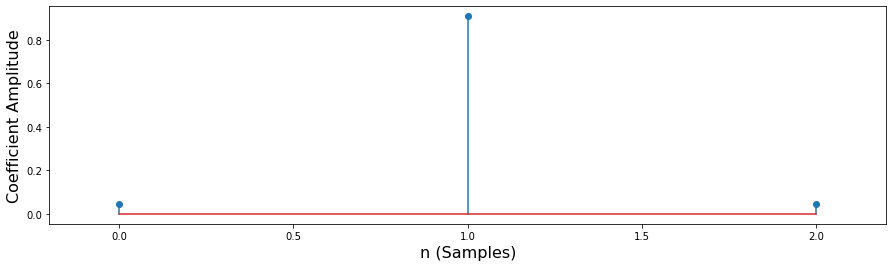

In [11]:
fc = 0.5
Ncoefs =3

bLP1 = firwin(Ncoefs,fc)
print('Lowpass numerator coefficients: ',bLP1)

plt.figure(figsize=(15, 4))
plt.stem(bLP1)

plt.xlim([-.2, Ncoefs-1+0.2])
plt.xlabel('n (Samples)',size=16)
plt.ylabel('Coefficient Amplitude',size=16)
plt.show()

**Figure 10. Illustration of the optimal filter coefficients when $Ncoeffs=3$ is chosen for the low-pass filtering operation.**

I've written out the coefficients so that you can see them (and note that they are symmetric!).  Let's now check out the effect of increasing the order of the approximation by increasing the number of coefficients (numtaps) to 41 and 101.

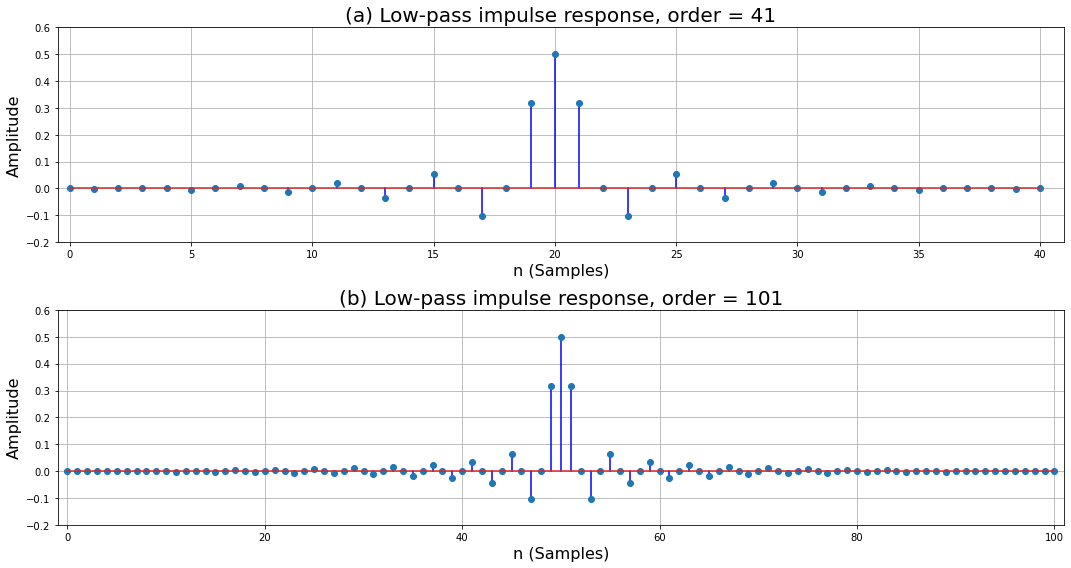

In [12]:
nc2=41
nc3=101

bLP2 = firwin(nc2, fc)
bLP3 = firwin(nc3, fc)

plt.figure(figsize=(15, 8))

plt.subplot(2,1,1)
plt.stem(np.arange(nc2), bLP2,'b'),
plt.xlabel('n (Samples)',size=16)
plt.title('(a) Low-pass impulse response, order = 41',size=20)
plt.ylim([-.2,.6]);plt.xlim([-.5, nc2])
plt.ylabel('Amplitude',size=16)
plt.grid(True)

plt.subplot(2,1,2)
plt.stem(np.arange(nc3), bLP3,'b')
plt.title('(b) Low-pass impulse response, order = 101',size=20)
plt.xlabel('n (Samples)',size=16)
plt.ylabel('Amplitude',size=16)
plt.grid(True)

plt.ylim([-.2,.6]);plt.xlim([-1, nc3]);

plt.tight_layout();
plt.show()

**Figure 11. Illustrating the impulse response of different orders of low-pass FIR filter. (a) 41 coefficients. (b) 101 coefficients.** 

In the above examples, note the following:

1. Each impulse response has $numtaps+1$ impulses

2. The filter is delayed by $numtaps/2$ for causal realization

How does this affect the frequency responses of the operators?  To examine this we can use the *scipy.signal* command **freqz** which will give you the frequency response of the filter.

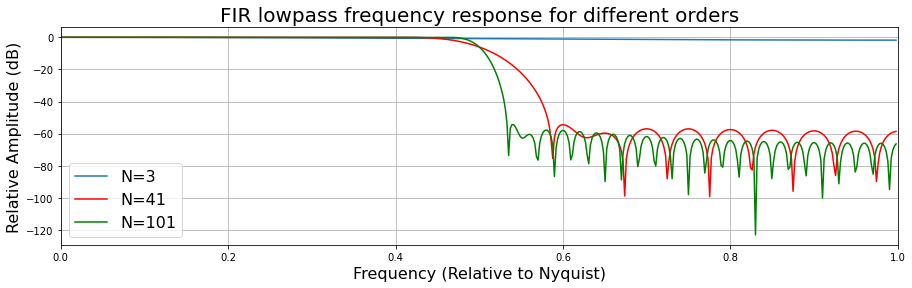

In [13]:
w, H_LP1 = freqz(bLP1,1)
w, H_LP2 = freqz(bLP2,1)
w, H_LP3 = freqz(bLP3,1)

plt.figure(figsize=(15, 4))
plt.grid(True)
plt.plot(w/(np.pi),20*np.log10(abs(H_LP1)))
plt.plot(w/(np.pi),20*np.log10(abs(H_LP2)),'r')
plt.plot(w/(np.pi),20*np.log10(abs(H_LP3)),'g')
plt.legend(('N=3','N=41','N=101'),fontsize=16)
plt.title('FIR lowpass frequency response for different orders',size=20)
plt.ylabel('Relative Amplitude (dB)',size=16)
plt.xlabel('Frequency (Relative to Nyquist)',size=16)
plt.xlim(0,1)
plt.show()

**Figure 12. Resulting quality of the low-pass filtering operation for different orders.  Vertical scale is in dB down.**

Note that we are plotting the y-axis in terms of dB, which is a logarithmic scale. For reference, a drop of about 60 dB in energy is the difference between a sound of a loud power lawnmower and a quiet library setting. As the order of the filter increases, the filter's transition band becomes narrower and frequency response becomes sharper through cut-off frequency (which is $0.5f_c/f_s$ for this case).  Also, the filter is delayed by $ numtaps / 2 $ for causality reasons.

# High-pass filtering with FIR filters

Let's now look at high-pass filtering use the similar approach as before.  We can actually use the same procedure as before, but pass an additional argument to *firwin*: *pass_zero=False*.  Essentially, this says "take -1 of what we did previously!

Here's the examples for the 41- and 101-point high-pass filter responses:

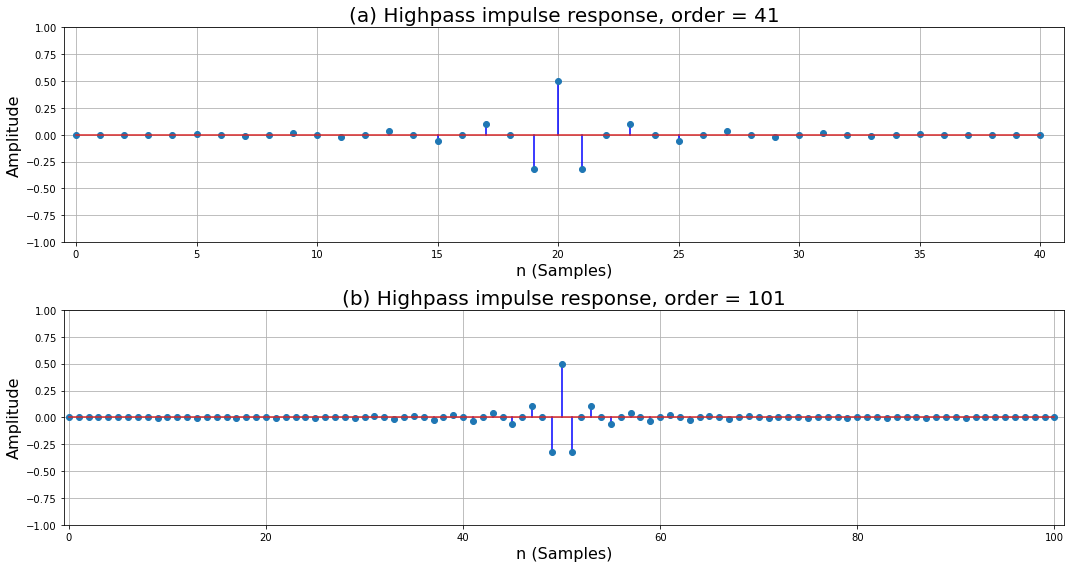

In [14]:
bHP2 = firwin(nc2, fc,pass_zero=False)
bHP3 = firwin(nc3, fc,pass_zero=False)

plt.figure(figsize=(15, 8))

plt.subplot(2,1,1)
plt.stem(np.arange(nc2), bHP2,'b')
plt.xlabel('n (Samples)',size=16)
plt.ylabel('Amplitude',size=16)
plt.title('(a) Highpass impulse response, order = 41',size=20)
plt.ylim([-1,1]);plt.xlim([-.5, nc2])
plt.grid(True)

plt.subplot(2,1,2)
plt.stem(np.arange(nc3), bHP3,'b')
plt.xlabel('n (Samples)',size=16)
plt.ylabel('Amplitude',size=16)
plt.title('(b) Highpass impulse response, order = 101',size=20)
plt.ylim([-1,1]);plt.xlim([-.5, nc3])
plt.grid(True)

plt.tight_layout();plt.show()

**Figure 13. Illustrating the impulse response of different orders of high-pass FIR filter. (a) 41 coefficients. (b) 101 coeffiients.** 

Let's now look at the frequency response for the different orders:

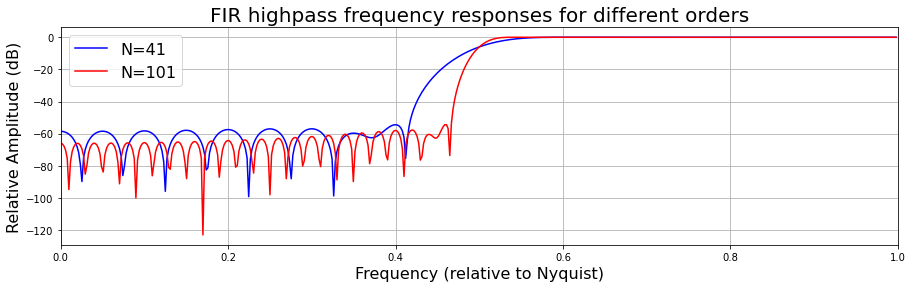

In [15]:
w, H_HP2 = freqz(bHP2,1)
w, H_HP3 = freqz(bHP3,1)

plt.figure(figsize=(15, 4))

plt.plot(w/np.pi,20*np.log10(abs(H_HP2)),'b')
plt.grid(True)
plt.plot(w/np.pi,20*np.log10(abs(H_HP3)),'r')

plt.legend(('N=41','N=101'),fontsize=16)
plt.title('FIR highpass frequency responses for different orders',size=20)
plt.ylabel('Relative Amplitude (dB)',size=16)
plt.xlabel('Frequency (relative to Nyquist)',size=16)
plt.xlim(0,1)
plt.show()

**Figure 12. Resulting quality of the high-pass FIR filtering operation for different orders.  Vertical scale is in dB down.**

# Bandpass filtering with FIR filters

We also may want to apply a bandpass filter that is the combination of the low- and high-pass filtering results.  To do this we can again call *firwin* in a modified way.  Instead of giving a single $f_c$, we can give two values that are interpreted as the low- and high-cut frequencies, $f_{lc}$ and $f_{hc}$, respectively. The example we are looking at uses $f_{lc}=0.2$ and $f_{hc}=0.4$.

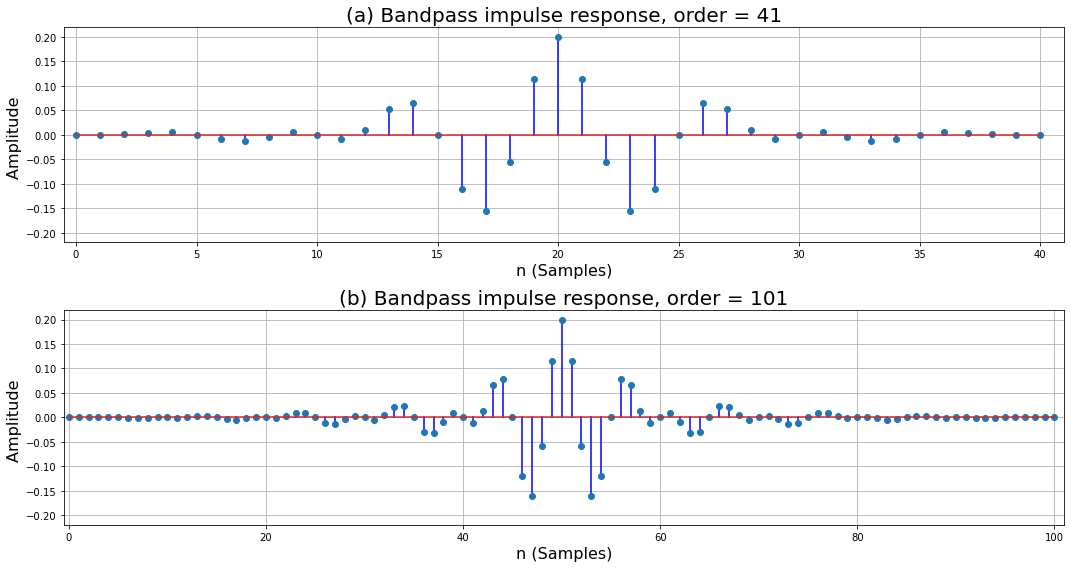

In [16]:
bBP2 = firwin(nc2, [0.2, 0.4],pass_zero=False)
bBP3 = firwin(nc3, [0.2, 0.4],pass_zero=False)

plt.figure(figsize=(15, 8))

plt.subplot(2,1,1)
plt.stem(np.arange(nc2), bBP2,'b')
plt.xlabel('n (Samples)',size=16)
plt.ylabel('Amplitude ',size=16)
plt.title('(a) Bandpass impulse response, order = 41',size=20)
plt.ylim([-1.1*np.max(np.abs(bBP2)),1.1*np.max(np.abs(bBP2))]);
plt.xlim([-.5, nc2])
plt.grid(True)


plt.subplot(2,1,2)
plt.stem(np.arange(nc3), bBP3,'b')
plt.xlabel('n (Samples)',size=16)
plt.ylabel('Amplitude ',size=16)
plt.title('(b) Bandpass impulse response, order = 101',size=20)
plt.ylim([-1.1*np.max(np.abs(bBP3)),1.1*np.max(np.abs(bBP3))]);
plt.xlim([-.5, nc3])
plt.grid(True)

plt.tight_layout();plt.show()

**Figure 14. Illustrating the impulse response of different orders of band-pass FIR filters. (a) 41 coefficients. (b) 101 coefficients.** 


Let's look at the frequency responses:

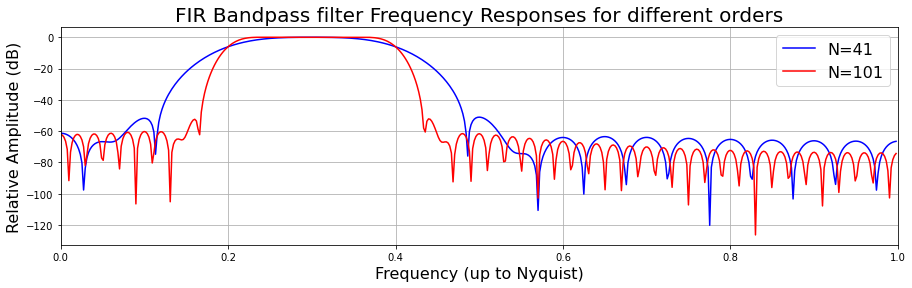

In [17]:
w, H_HP2 = freqz(bBP2,1)
w, H_HP3 = freqz(bBP3,1)

plt.figure(figsize=(15, 4))

plt.plot(w/np.pi,20*np.log10(abs(H_HP2)),'b')
plt.plot(w/np.pi,20*np.log10(abs(H_HP3)),'r')

plt.legend(('N=41','N=101'),fontsize=16)
plt.grid(True)
plt.title('FIR Bandpass filter Frequency Responses for different orders',size=20)
plt.ylabel('Relative Amplitude (dB)',size=16)
plt.xlabel('Frequency (up to Nyquist)',size=16)
plt.xlim(0,1)
plt.show()

**Figure 15. Illustrating the impulse response of different orders of high-pass FIR filter. (a) 41 coefficients. (b) 101 coefficients.** 

# Band-reject using FIR filters

Finally, the last permutation of the cases is to look at band reject.  We can do the same as the bandpass filtering above, but we have to remove the *pass-zero* option (or set it to True).

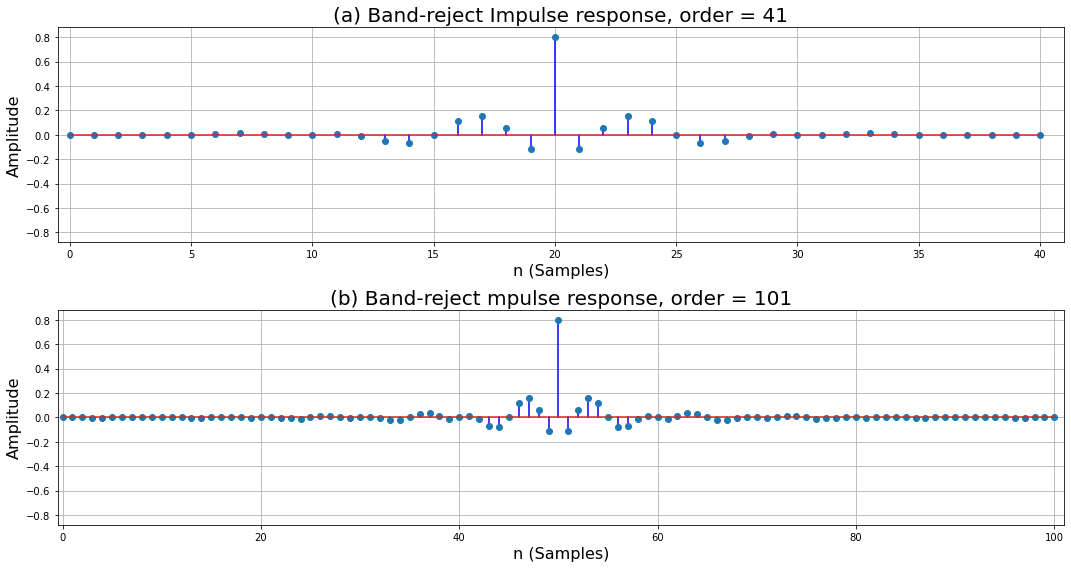

In [18]:
bBR2 = firwin(nc2, [0.2, 0.4],pass_zero=True)
bBR3 = firwin(nc3, [0.2, 0.4],pass_zero=True)

plt.figure(figsize=(15, 8))

plt.subplot(2,1,1)
plt.stem(np.arange(nc2), bBR2,'b')
plt.xlabel('n (Samples)',size=16)
plt.ylabel('Amplitude',size=16)
plt.title('(a) Band-reject Impulse response, order = 41',size=20)
plt.ylim([-1.1*np.max(np.abs(bBR2)),1.1*np.max(np.abs(bBR2))]);
plt.xlim([-.5, nc2])
plt.grid(True)

plt.subplot(2,1,2)
plt.stem(np.arange(nc3), bBR3,'b')
plt.xlabel('n (Samples)',size=16)
plt.ylabel('Amplitude',size=16)
plt.title('(b) Band-reject mpulse response, order = 101',size=20)
plt.ylim([-1.1*np.max(np.abs(bBR3)),1.1*np.max(np.abs(bBR3))]);
plt.xlim([-.5, nc3])
plt.grid(True)

plt.tight_layout();plt.show()

**Figure 16. Illustrating the impulse response of different orders of band-reject filters. (a) 41 coefficients. (b) 101 coefficients.** 

And also the frequency response:

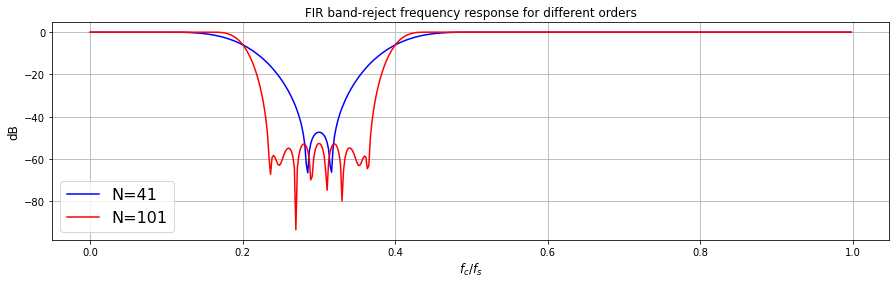

In [50]:
w, H_BR2 = freqz(bBR2,1)
w, H_BR3 = freqz(bBR3,1)

plt.figure(figsize=(15, 4))
plt.plot(w/np.pi,20*np.log10(abs(H_BR2)),'b')
plt.grid(True)
plt.plot(w/np.pi,20*np.log10(abs(H_BR3)),'r')

plt.legend(('N=41','N=101'),fontsize=16)
plt.title('FIR band-reject frequency response for different orders')
plt.ylabel('dB',size=12)
plt.xlabel('$f_c/f_s$',size=12)
plt.show()

**Figure 17. Illustrating the impulse response of different orders of band-reject filters. (a) 41 coefficients. (b) 101 coeffiients.** 

# Example: Filtering a multi-tone signal

Now we will generate a multi-component sinusoidal signal with frequencies 440 Hz, 880 Hz and 1320 Hz that is sampled at $f_s$=44100 Hz. These frequencies are equivalent to the A note below the middle C note on a piano as well the two octaves above it.  We choose an arbitrary duration of 3s.

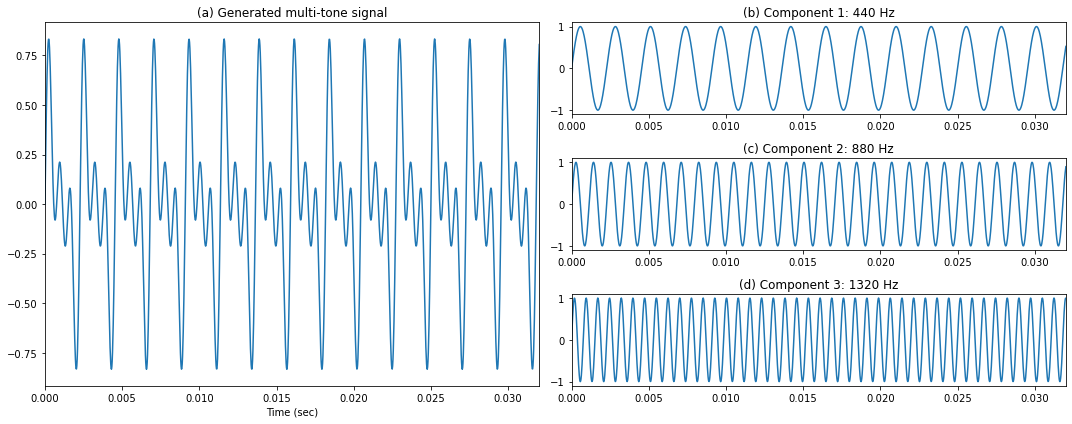

In [20]:
fs = 44100.0
ncut=1500
t = np.arange(3*fs) /fs

comp1 = np.sin(2*np.pi*1*440*t);
comp2 = np.sin(2*np.pi*2*440*t);
comp3 = np.sin(2*np.pi*3*440*t);

x = (comp1+comp2+comp3)/3.0

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(t[0:ncut],x[0:ncut])
plt.xlabel('Time (sec)');
plt.title('(a) Generated multi-tone signal');
plt.xlim(0,0.032)
plt.subplot(3,2,2)
plt.plot(t[0:ncut],comp1[0:ncut])
plt.title('(b) Component 1: 440 Hz')
plt.xlim(0,0.032)
plt.subplot(3,2,4)
plt.plot(t[0:ncut],comp2[0:ncut])
plt.title('(c) Component 2: 880 Hz')
plt.xlim(0,0.032)
plt.subplot(3,2,6)
plt.plot(t[0:ncut],comp3[0:ncut])
plt.title('(d) Component 3: 1320 Hz')
plt.xlim(0,0.032)
plt.tight_layout();plt.show()

**Figure 18. (a) Superposition of three notes comprised of (b) low (440 Hz), (c) medium (880 Hz) and (d) high (1320 Hz) frequencies.**

Let's listen to these three notes superimposed:

In [21]:
ipd.Audio(x, rate=fs) 

## Low-pass filtering

Let's look at low-pass filtering of the above that will pass only the 440Hz components.  For this we have to design a lowpass filter with a cut-off frequency larger than 440 Hz. Let's pick cut-off as 660 Hz and order as 101 points.  To apply the filter we calculated with *firwin* we use the *lfilter* routine:

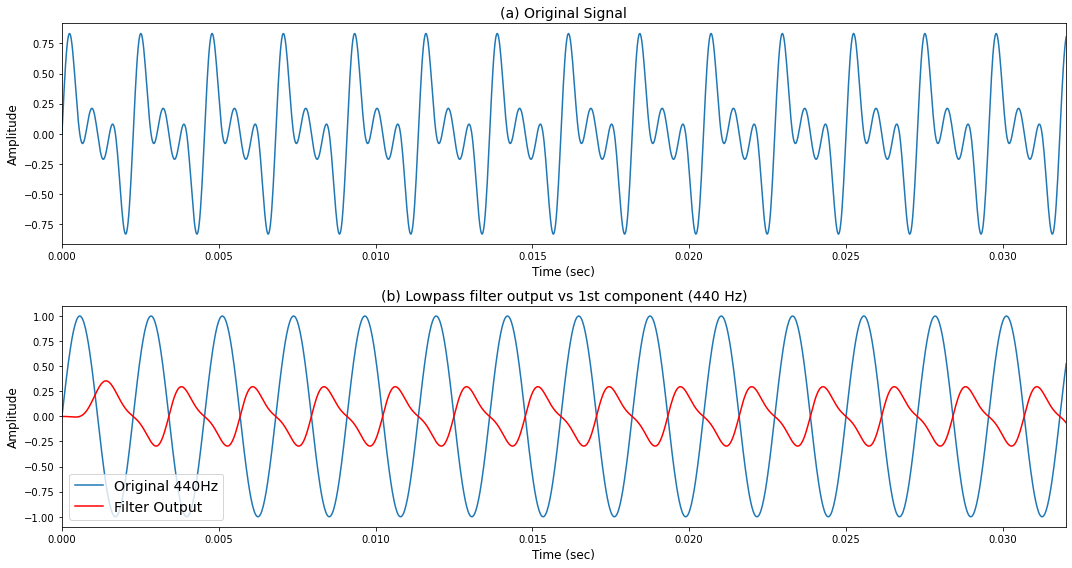

In [22]:
wcLP = 660*2/fs

bLP = firwin(101,wcLP)

outputLP = lfilter(bLP,1,x)

plt.figure(figsize=(15, 8))

plt.subplot(2,1,1)
plt.plot(t[0:ncut],x[0:ncut])
plt.xlabel('Time (sec)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title('(a) Original Signal',size=14)
plt.xlim(0,0.032)

plt.subplot(2,1,2)
plt.plot(t[0:ncut],comp1[0:ncut])
plt.plot(t[0:ncut],outputLP[0:ncut],'r')
plt.xlabel('Time (sec)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title('(b) Lowpass filter output vs 1st component (440 Hz)',size=14)
plt.legend(('Original 440Hz','Filter Output'),fontsize=14)
plt.xlim(0,0.032)

plt.tight_layout();plt.show()

**Figure 19. Low-pass filtered result showing (a) original signal and (b) signal after filtering out all but the lowest-frequency component.**

Let's listen to the low-pass filtered signal as well as the original:

In [23]:
ipd.Audio(outputLP, rate=fs) 

In [24]:
ipd.Audio(x, rate=fs) 

## High-pass filtering


Let's now do some high-pass filtering to remove only frequencies 440 Hz and 880 Hz from the original signal. Thus, we need to design a highpass filter with a cut-off frequency that is smaller than 1320 Hz. Let's pick it as 1100 Hz and order  101.

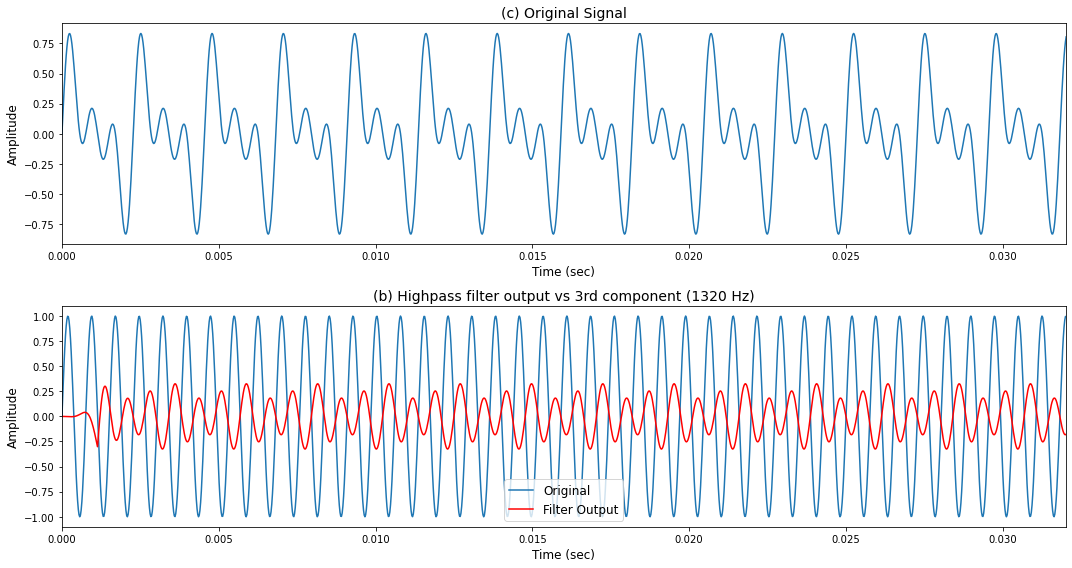

In [25]:
wcHP = 1100*2/fs

bHP = firwin(101,wcHP,pass_zero=False)

outputHP = lfilter(bHP,1,x)

plt.figure(figsize=(15, 8))

plt.subplot(2,1,1)
plt.plot(t[0:ncut],x[0:ncut])
plt.xlabel('Time (sec)',size=12);
plt.ylabel('Amplitude',size=12);
plt.title('(c) Original Signal',size=14)
plt.xlim(0,0.032)

plt.subplot(2,1,2)
plt.plot(t[0:ncut],comp3[0:ncut])
plt.plot(t[0:ncut],outputHP[0:ncut],'r')
plt.xlabel('Time (sec)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title('(b) Highpass filter output vs 3rd component (1320 Hz)',size=14);
plt.legend(('Original','Filter Output'),fontsize=12)
plt.xlim(0,0.032)

plt.tight_layout();plt.show()

**Figure 20. High-pass filtered result showing (a) original signal and (b) signal after filtering out all but the highest-frequency component.**

Let's now listed to the high-passed and original signals:

In [26]:
ipd.Audio(outputHP, rate=fs)

In [27]:
ipd.Audio(x, rate=fs)

## Bandpass filtering

Let's now do some band-pass filtering to remove only frequencies 440 Hz and 1320 Hz from the original signal. Thus, we need to design a bandpass filter with a cut-off frequency that is greater than 440Hz but smaller than 1320 Hz. Let's pick it as 660 and 1100 Hz and order 101.

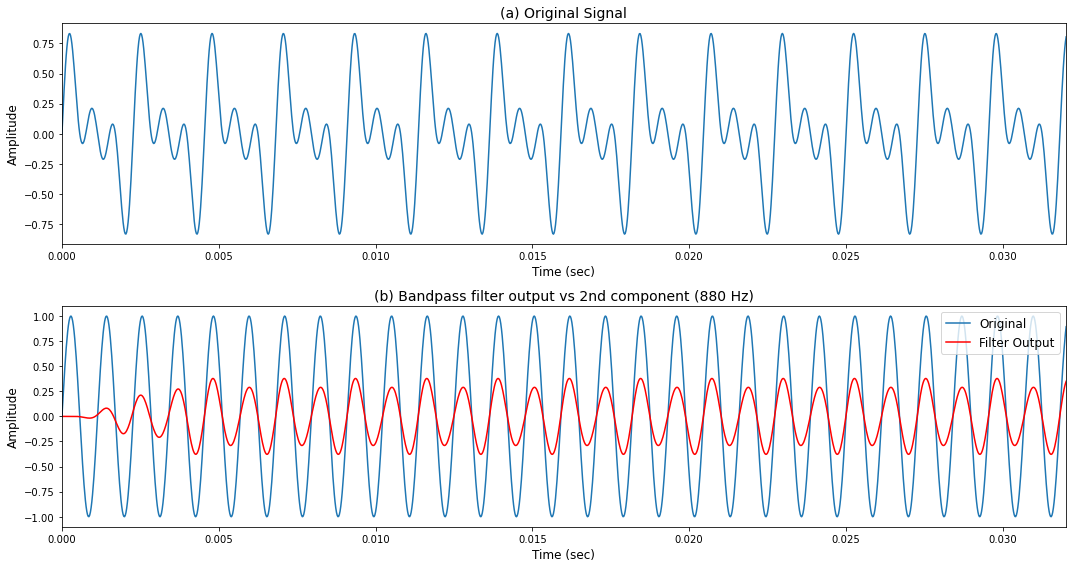

In [28]:
wcBP = [660*2/fs, 1100*2/fs]

bBP = firwin(201,wcBP,pass_zero=False)

outputBP = lfilter(bBP,1,x)

plt.figure(figsize=(15, 8))

plt.subplot(2,1,1)
plt.plot(t[0:ncut],x[0:ncut])
plt.xlabel('Time (sec)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title('(a) Original Signal',size=14)
plt.xlim(0,0.032)

plt.subplot(2,1,2)
plt.plot(t[0:ncut],comp2[0:ncut])
plt.plot(t[0:ncut],outputBP[0:ncut],'r')
plt.xlabel('Time (sec)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title('(b) Bandpass filter output vs 2nd component (880 Hz)',size=14)
plt.legend(('Original','Filter Output'),fontsize=12)
plt.xlim(0,0.032)

plt.tight_layout();plt.show()

**Figure 21. High-pass filtered result showing (a) original signal and (b) signal after filtering out all but the middle-frequency component.**

Let's now listed to the bandpassed and original signals:

In [29]:
ipd.Audio(outputBP, rate=fs) 

In [30]:
ipd.Audio(x, rate=fs)

## Band-reject filtering

Finally, let's now do some band-reject filtering to remove only the 880Hz frequency while keeping that at 440 Hz and 1340 Hz. Thus, we need to design a band-reject filter.  Let's do this in a similar way as above by pass an extra argument that states we're going to have zero in the pass band.

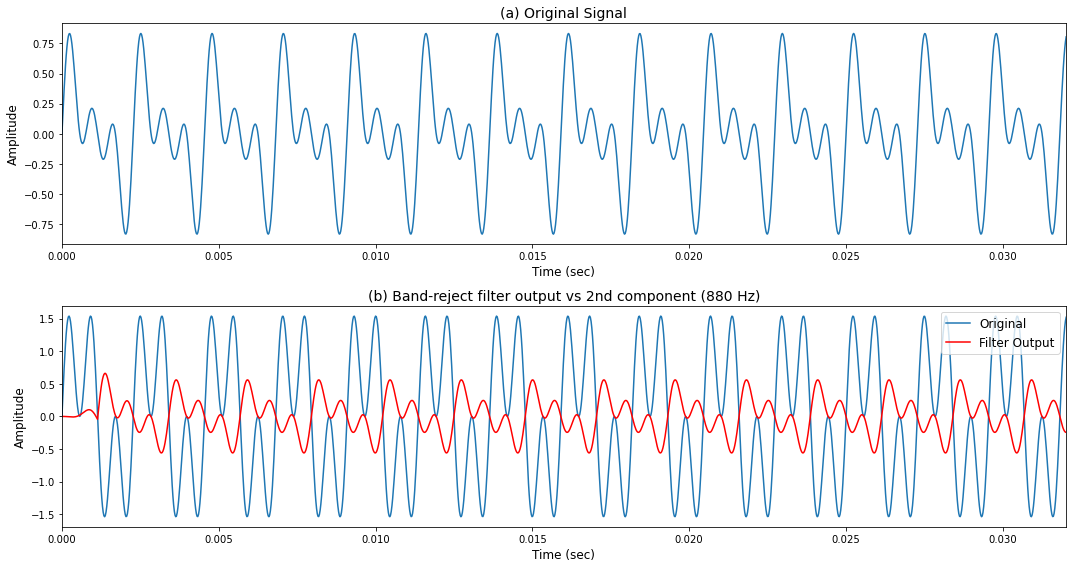

In [31]:
wcBR = [660*2/fs, 1100*2/fs]

bBR = firwin(101,wcBR,pass_zero=True)

outputBR = lfilter(bBR,1,x)

plt.figure(figsize=(15, 8))

plt.subplot(2,1,1)
plt.plot(t[0:ncut],x[0:ncut])
plt.xlabel('Time (sec)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title('(a) Original Signal',size=14)
plt.xlim(0,0.032)

plt.subplot(2,1,2)
plt.plot(t[0:ncut],comp1[0:ncut]+comp3[0:ncut])
plt.plot(t[0:ncut],outputBR[0:ncut],'r')
plt.xlabel('Time (sec)',size=12)
plt.ylabel('Amplitude',size=12)
plt.title('(b) Band-reject filter output vs 2nd component (880 Hz)',size=14)
plt.legend(('Original','Filter Output'),fontsize=12)
plt.xlim(0,0.032)

plt.tight_layout();plt.show()

**Figure 22. Band-reject filtered result showing (a) original signal and (b) signal after filtering out only the middle-frequency component.**

Let's now listed to the band-rejected and original signals:

In [32]:
ipd.Audio(outputBR, rate=fs) 

In [33]:
ipd.Audio(x, rate=fs) 

# Low-pass filtering with IIR operators

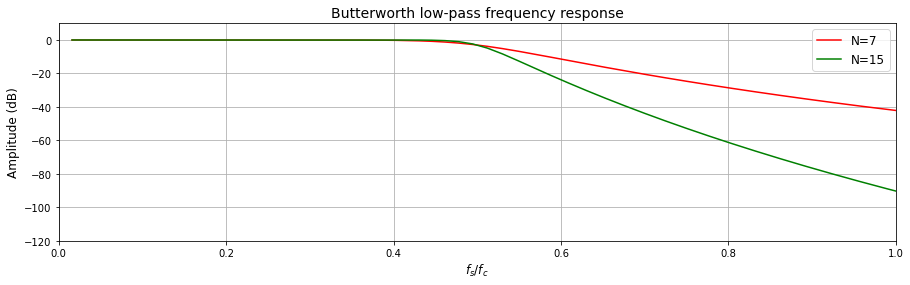

In [34]:
corner = 0.5

b1, a1 = butter(7, corner*2.*np.pi, 'low', analog=True)
w1, h1 = freqs(b1, a1)

b2, a2 = butter(15, corner*2.*np.pi, 'low', analog=True)
w2, h2 = freqs(b2, a2)

plt.figure(figsize=(15,4))
plt.plot(w1 / (2*np.pi), 20 * np.log10(abs(h1)),'r',w2 / (2*np.pi), 20 * np.log10(abs(h2)),'g')
plt.title('Butterworth low-pass frequency response',size=14)
plt.xlabel('$f_s/f_c$',size=12)
plt.ylabel('Amplitude (dB)',size=12)
plt.xlim(0,1);plt.ylim(-120,10)
plt.grid(which='both', axis='both')
plt.legend(('N=7','N=15'),fontsize=12)
plt.show()

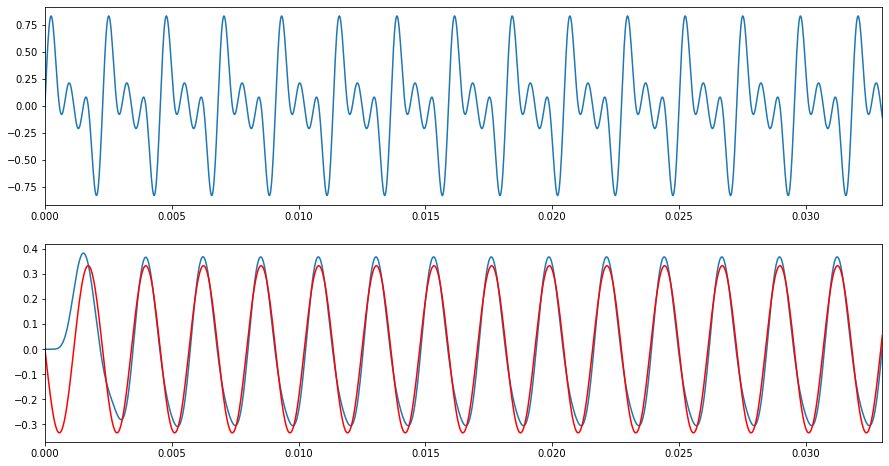

In [35]:
wcLP = 2*660/44100

sos = butter(7, wcLP, 'lowpass', output='sos')
IIRLP = sosfilt(sos, x)

plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(t[0:ncut],x[0:ncut])
plt.xlim(0,0.033)
plt.subplot(212)
plt.plot(t[0:ncut],IIRLP[0:ncut])
plt.plot(t[0:ncut],-comp1[0:ncut]/3,'r')
plt.xlim(0,0.033)

plt.show()

In [36]:
ipd.Audio(IIRLP, rate=fs) 

In [37]:
ipd.Audio(x, rate=fs) 

# High-pass filtering with IIR operator

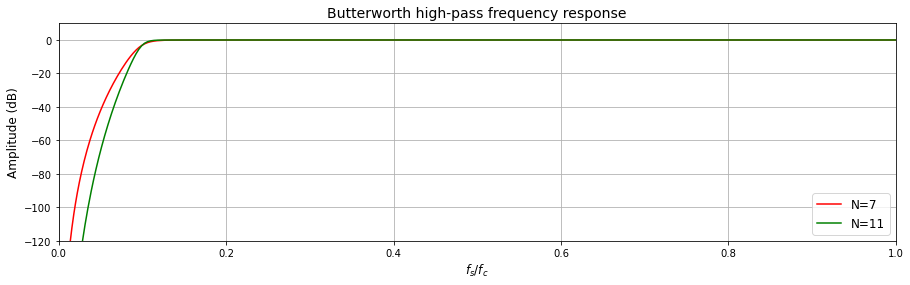

In [18]:
corner = 0.1

b1, a1 = butter(7, corner*2.*np.pi, 'high', analog=True)
w1, h1 = freqs(b1, a1)

b2, a2 = butter(11, corner*2.*np.pi, 'high', analog=True)
w2, h2 = freqs(b2, a2)

plt.figure(figsize=(15,4))
plt.plot(w1 / (2*np.pi), 20 * np.log10(abs(h1)),'r',w2 / (2*np.pi), 20 * np.log10(abs(h2)),'g')
plt.title('Butterworth high-pass frequency response',size=14)
plt.xlabel('$f_s/f_c$',size=12)
plt.ylabel('Amplitude (dB)',size=12)
plt.xlim(0,1);plt.ylim(-120,10)
plt.grid(which='both', axis='both')
plt.legend(('N=7','N=11'),fontsize=12)
plt.show()

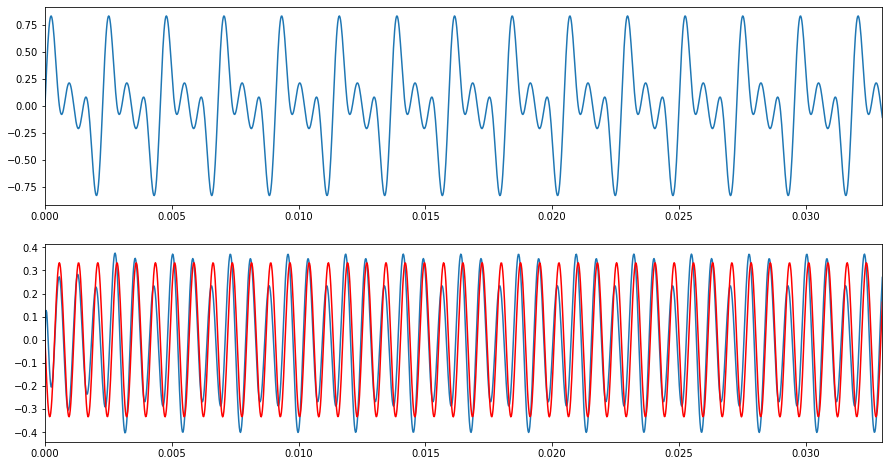

In [55]:
wcLP = 2*1100/44100

sos = butter(6, wcLP, 'highpass', output='sos')
IIRHP = sosfilt(sos, x)

plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(t[0:ncut],x[0:ncut])
plt.xlim(0,0.033)

plt.subplot(212)
plt.plot(t[0:ncut],IIRHP[0:ncut])
plt.plot(t[0:ncut],-comp3[0:ncut]/3,'r')
plt.xlim(0,0.033)

plt.show()

In [40]:
ipd.Audio(IIRHP, rate=fs) 

In [41]:
ipd.Audio(x, rate=fs) 

# Band-pass filtering with IIR operator

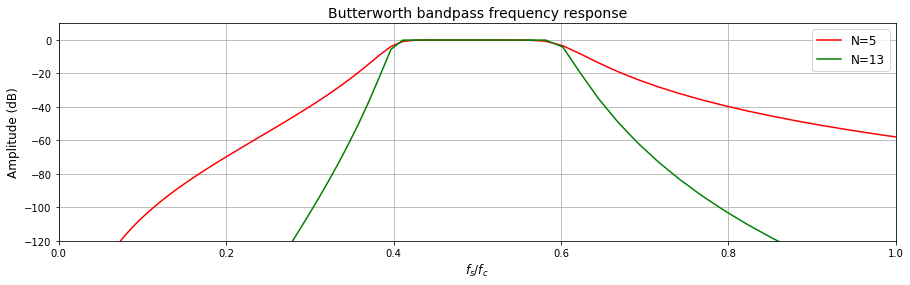

In [42]:
corners = [0.4*2.*np.pi,0.6*2.*np.pi]

b1, a1 = butter(5, corners, 'pass', analog=True)
w1, h1 = freqs(b1, a1)

b2, a2 = butter(13, corners, 'pass', analog=True)
w2, h2 = freqs(b2, a2)

plt.figure(figsize=(15,4))
plt.plot(w1 / (2*np.pi), 20 * np.log10(abs(h1)),'r',w2 / (2*np.pi), 20 * np.log10(abs(h2)),'g')
plt.title('Butterworth bandpass frequency response',size=14)
plt.xlabel('$f_s/f_c$',size=12)
plt.ylabel('Amplitude (dB)',size=12)
plt.xlim(0,1);plt.ylim(-120,10)
plt.grid(which='both', axis='both')
plt.legend(('N=5','N=13'),fontsize=12)
plt.show()

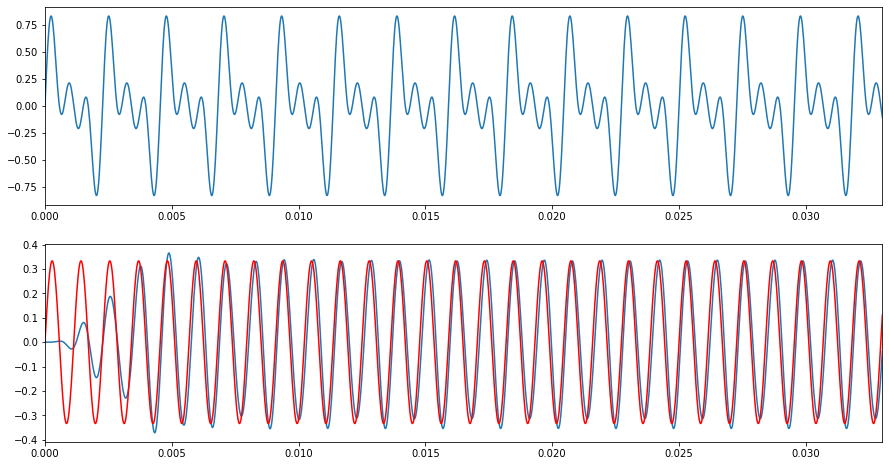

In [43]:
wcBP = [2*660/44100,2*1100/44100]

sos = butter(5, wcBP, 'pass', output='sos')
IIRBP = sosfilt(sos, x)

plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(t[0:ncut],x[0:ncut])
plt.xlim(0,0.033)

plt.subplot(212)
plt.plot(t[0:ncut],IIRBP[0:ncut])
plt.plot(t[0:ncut],comp2[0:ncut]/3,'r')

plt.xlim(0,0.033)

plt.show()

In [44]:
ipd.Audio(IIRBP, rate=fs) 

In [45]:
ipd.Audio(x, rate=fs) 

## Band-reject filtering with IIR operator

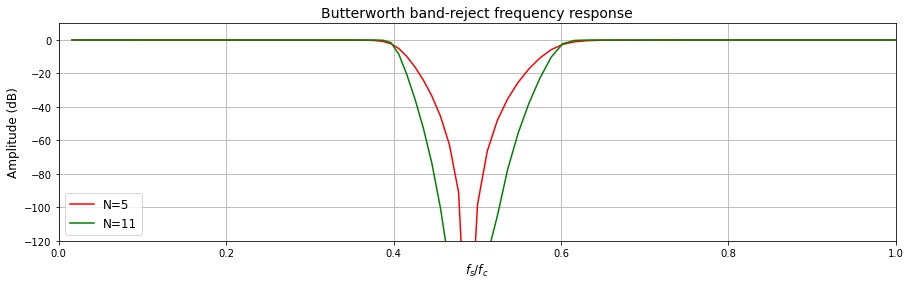

In [46]:
corners = [0.4*2.*np.pi,0.6*2.*np.pi]

b1, a1 = butter(5, corners, 'stop', analog=True)
w1, h1 = freqs(b1, a1)

b2, a2 = butter(11, corners, 'stop', analog=True)
w2, h2 = freqs(b2, a2)

plt.figure(figsize=(15,4))
plt.plot(w1 / (2*np.pi), 20 * np.log10(abs(h1)),'r',w2 / (2*np.pi), 20 * np.log10(abs(h2)),'g')
plt.title('Butterworth band-reject frequency response',size=14)
plt.xlabel('$f_s/f_c$',size=12)
plt.ylabel('Amplitude (dB)',size=12)
plt.xlim(0,1);plt.ylim(-120,10)
plt.grid(which='both', axis='both')
plt.legend(('N=5','N=11'),fontsize=12)
plt.show()

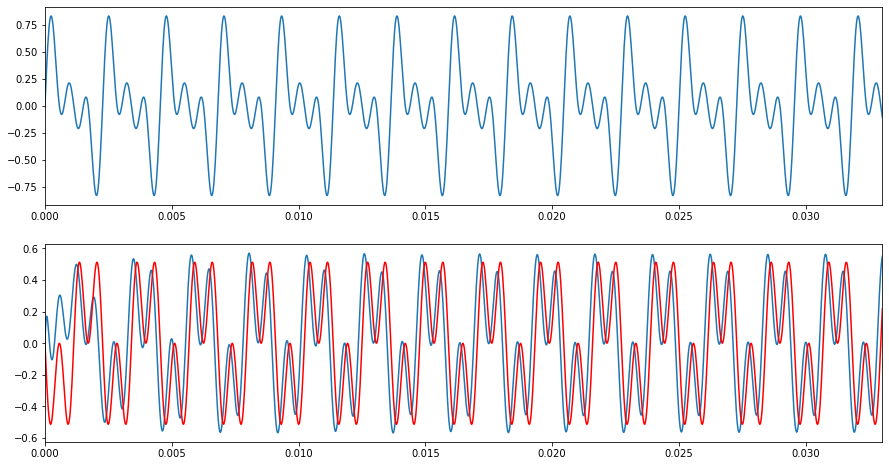

In [47]:
wcBR = [2*660/44100,2*1100/44100]

sos = butter(11, wcBR, 'stop', output='sos')
IIRBR = sosfilt(sos, x)

plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(t[0:ncut],x[0:ncut])
plt.xlim(0,0.033)

plt.subplot(212)
plt.plot(t[0:ncut],IIRBR[0:ncut])
plt.plot(t[0:ncut],-(comp1[0:ncut]+comp3[0:ncut])/3,'r')

plt.xlim(0,0.033)

plt.show()

In [48]:
ipd.Audio(IIRBR, rate=fs) 

In [49]:
ipd.Audio(x, rate=fs) 